**Riemann Solver**

In [1]:
#-------Author - Swadesh Suman
#-------Location - McGill University
#-------McGill ID - 261097252
#-------Date - 18th Feb, 2024
#-------Course - MECH 516 (Computational Gasdynamics)

In [2]:
import numpy as np  
import matplotlib.pyplot as plt
import math as math
import pandas as pd

In [3]:

#--------------------****Rienman Solver****------------------------------------------------------------------------------------- 

def riemann_solver(primitive_left, primitive_right, gamma_gas, gas_constant, x_initial, x_range, time_initial, time_location):
    

    ## Function to calculate shock wave function
    def shock_fun(p_initial, density, pressure, gamma,sound_speed):
    
        numerator = 2 / ((gamma + 1) * density)
        denominator = p_initial + (((gamma - 1) / (gamma + 1)) * pressure)
        ratio = np.sqrt(numerator / denominator)
        return ((p_initial - pressure) * ratio)

    ## Function to calculate expansion fan function
    def expansion_fun(p_initial, density, pressure, gamma, sound_speed):
        power = (gamma - 1) / (2 * gamma)
        multiply = (2 * sound_speed) / (gamma - 1)
        p_ratio = p_initial / pressure
        return (multiply * ((p_ratio ** power) - 1))

    ## Function to calculate shock wave differential function
    def shock_diff(p_initial, density, pressure, gamma, sound_speed):
        numerator = 2 / ((gamma + 1) * density)
        denominator = p_initial + (((gamma - 1) / (gamma + 1)) * pressure)
        ratio = np.sqrt(numerator / denominator)
        num1 = p_initial - pressure
        deno1 = 2 * denominator
        return (ratio * (1 - (num1 / deno1)))
    
    ## Function to calculate expansion fan differential function
    def expansion_diff_fun(p_initial, density, pressure, gamma, sound_speed):
        power = -((gamma + 1) / (2 * gamma))
        p_ratio = p_initial / pressure
        return ((1 / (density * sound_speed)) * (p_ratio ** power))
    
    ## Function to calculate pressure and density at the contact surface location
    def contact_condition(pressure_star, density_right, velocity_right, pressure_right, gamma_right, sound_speed_right, density_left, \
                      velocity_left, pressure_left, gamma_left, sound_speed_left, tol):
        error = 10
        # to check if the pressure is less than zero and assign 0.001 if it is--
        if pressure_star < 0:  
            pressure_star = 1e-3
        while error > tol:
            
            # to define which function one have to used, based on one's location
            if pressure_star > pressure_left:
                fun_left = shock_fun(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
                fun_diff_left = shock_diff(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
            else:
                fun_left = expansion_fun(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
                fun_diff_left = expansion_diff_fun(pressure_star, density_left, pressure_left, gamma_left,sound_speed_left)
            
            if pressure_star > pressure_right:
                fun_right = shock_fun(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)
                fun_diff_right = shock_diff(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)
            else:
                fun_right = expansion_fun(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)
                fun_diff_right = expansion_diff_fun(pressure_star, density_right, pressure_right, gamma_right,sound_speed_right)

            # calculates the pressure fun
            pressure_fun = fun_left + fun_right + (velocity_right - velocity_left)
            
            # calculates the pressure differentiation function
            pressure_diff_fun = fun_diff_left + fun_diff_right

            # Netwon's method to find out the exact pressure
            pressure_new = pressure_star - (pressure_fun / pressure_diff_fun)

            # error to check the convergence of the newton's method
            error = np.abs(pressure_new - pressure_star )/pressure_star
            if (pressure_new < 0):
                pressure_star = 1e-3
            else:
                pressure_star = pressure_new
       
        # calculate the velocity star at the contact surface
        velocity_star = 0.5 * (velocity_left + velocity_right) + (0.5 * (fun_right - fun_left))
        return pressure_new, velocity_star

    # Input parameters-------------------------------------------------------------
    gamma_left, gamma_right = gamma_gas  # gamma of the gas on left and right
    gas_constant_left, gas_constant_right = gas_constant # gas constant 
    
    # density, velocity, and pressure
    density_left, velocity_left, pressure_left = primitive_left # density, velocity and pressure
    density_right, velocity_right, pressure_right = primitive_right

    # temperature calculation
    temperature_left = pressure_left / (gas_constant_left * density_left)
    temperature_right = pressure_right / (gas_constant_right * density_right)
    
    # speed of sound calculation
    sound_speed_left = np.sqrt((gamma_left * pressure_left)/ density_left)
    sound_speed_right = np.sqrt((gamma_right * pressure_right)/ density_right)

    # Checking if there is a vacuum condition -------------------------------------------------------------------
    if ((velocity_right - velocity_left) >= (2/((gamma_left)-1)*(sound_speed_left + sound_speed_right))):
        raise ValueError("The given conditions will produce vacuum inside and this code is not made to handle those conditions")
        
    # tolrance value for the Newton method to solve the pressure and velocity at the contact surface
    tol = 1e-6  

    # Acoustic solution approximation to find pressure_star_initial ---------------------------------------------------------------------
    numerator_acoustic = (pressure_left * density_right * sound_speed_right) + (pressure_right * density_left * sound_speed_left)  \
                        + ((velocity_left - velocity_right) * (density_left * sound_speed_left * density_right * sound_speed_right))
    denominator_acoustic = (density_right * sound_speed_right) + (density_left * sound_speed_left)

    pressure_star = numerator_acoustic / denominator_acoustic

    # Finding the actual pressure and velocity star conditions at the contact surface
    # The function return the pressure and velocity values near the contact surface region
    p_actual, u_actual = contact_condition(pressure_star, density_right, velocity_right, pressure_right, gamma_right, \
                                           sound_speed_right, density_left, velocity_left, pressure_left, gamma_left, sound_speed_left, tol)

    #*****************************************************************************************#
    # Solution for the xt plot
    x_location = np.linspace(x_range[0], x_range[1], 100)
    
    
    velocity_star = u_actual
    pressure_star = p_actual

    # Contact surface - velocity line plotting
    if (velocity_star != 0):
        cs_t = (x_location - x_initial)/velocity_star
        plt.plot(x_location, cs_t, linestyle = 'dashdot', label = 'Contact surface')
    else:
        plt.axvline(x=0, linestyle='--',label = 'Contact surface')
    
    #For the left expansion wave-----------------------------------------------
    if pressure_star <= pressure_left: # we get left expansion wave 
        density_star_left = density_left*((pressure_star/pressure_left)**(1/gamma_left))
        
        # sound speed star left side 
        sound_star_left = sound_speed_left*((pressure_star/pressure_left)**((gamma_left-1)/(2*gamma_left)))
        
        # speed of head and tail of expansion wave
        speed_head_left = velocity_left - sound_speed_left
        speed_tail_left = velocity_star - sound_star_left

        # location of expansion head left
        exHeadLeft = (x_location - x_initial)/speed_head_left

        # location of the expansion tail eft
        exTailLeft = (x_location - x_initial)/speed_tail_left

        # plotting the expansion head and tail
        plt.plot(x_location, exHeadLeft, label = 'Expansion wave head - left')
        plt.plot(x_location, exTailLeft, label = 'Expansion wave tail - left')
 
    else:
        # we have a left shock wave --------------------------
        pressure_ratio_left = pressure_star/pressure_left
    
        # shock speed calculation
        shock_mach_left = np.sqrt(((pressure_ratio_left*(gamma_left+1)) + (gamma_left - 1))/(2*gamma_left))

        # calculation of the shock speed on left side
        shock_speed_left = velocity_left - (sound_speed_left*shock_mach_left)

        # calculation of the location of left shock
        shLeft = (x_location - x_initial)/shock_speed_left

        # plotting the left shock
        plt.plot(x_location, shLeft, label = 'Left facing Shock')
        
    #else:
    # Finding the values in the RIGHT side ---------------------------------
    if pressure_star <= pressure_right: # we get right expansion wave
        density_star_right =density_right*((pressure_star/pressure_right)**(1/gamma_right))
        # sound speed star right side 
        sound_star_right =sound_speed_right*((pressure_star/pressure_right)**((gamma_right - 1)/(2*gamma_right)))

         # speed of head and tail of expansion wave
        speed_head_right = velocity_right + sound_speed_right
        speed_tail_right = velocity_star + sound_star_right
        
        # location of expansion head right
        exHeadRight = (x_location - x_initial)/speed_head_right

        # location of expansion tail right
        exTailRight = (x_location - x_initial)/speed_tail_right

        # plotting the expansion head and tail
        plt.plot(x_location, exHeadRight, label = 'Expansion wave head - right')
        plt.plot(x_location, exTailRight, label = 'Expansion wave tail - right')
    
        
    else:  # we get right shock wave (pressure_star > pressure_left)
        pressure_ratio_right = pressure_star/pressure_right
        shock_mach_right = np.sqrt(((pressure_ratio_right*(gamma_right+1))+ (gamma_right - 1))/(2*gamma_right))
        shock_speed_right = velocity_right + (sound_speed_right*shock_mach_right)
    
        shRight = (x_location - x_initial)/shock_speed_right
        plt.plot(x_location, shRight, label = 'Right facing Shock')

    plt.ylim(0,time_location*5)
    plt.xlim(x_range[0],x_range[1])
    plt.xlabel('X-coordinate')
    plt.ylabel('Time')
    plt.grid(True)
    plt.minorticks_on()
    plt.title('X-T Diagram')
    plt.legend(loc='upper left')
    # Saving the figure
    plt.savefig('Problem_1_xt_dig.png', dpi = 300)
    plt.show()

    ## Calculation of density, velocity, and pressure at all locations, at a given time interval ----------
    x_values = []
    density_location = []
    velocity_location = []
    pressure_location = []
    
    N = 1000
    for j in range(1,N):
        x = -0.5 + ((1/N)*(j-0.5))
        x_values.append(x)
    
    i = 0
    for i in range(0,len(x_values)):
        x = x_values[i]
        xt_ratio = (x - x_initial) / (time_location - time_initial)  # to find x/t ratio
        if xt_ratio <= velocity_star:
            if (pressure_star <= pressure_left): # we get left expansion wave
                if (xt_ratio < speed_head_left):  # we are in the right of left head expansion wave
                    density_location.append(density_left)
                    velocity_location.append(velocity_left)
                    pressure_location.append(pressure_left)

                elif (xt_ratio > speed_tail_left): # we are in the left of left tail expansion wave
                    density_location.append(density_star_left)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)
                else:  # we are in the centre of the left expansion wave
                    velocity_inside_left = (2/(gamma_left + 1))*(sound_speed_left + (((gamma_left - 1)/2)*velocity_left) + xt_ratio)
                    
                    # For pressure there are two many variables, so we will break terms
                    p_2_left = velocity_left - xt_ratio
                    p_1_left = ((gamma_left - 1)/(gamma_left + 1))*(1/sound_speed_left)
                    p_power_left = (2*gamma_left)/(gamma_left - 1)
                    pressure_inside_left = pressure_left*((2/(gamma_left + 1)) + (p_1_left*p_2_left))**p_power_left;
                    density_inside_left = density_left* ((2/(gamma_left + 1)) +(p_1_left*p_2_left))**(2/(gamma_left - 1))
    
                    density_location.append(density_inside_left)
                    velocity_location.append(velocity_inside_left)
                    pressure_location.append(pressure_inside_left)
            else:  # we get left shock wave
                if xt_ratio < shock_speed_left:  # we are in the right of left shock wave
                    density_location.append(density_left)
                    velocity_location.append(velocity_left)
                    pressure_location.append(pressure_left)
                else:  # we are in the left of left shock wave
                    # since density is a huge term, we will break it down
                    num_den_1 = pressure_ratio_left + ((gamma_left-1)/(gamma_left+1))
                    deno_den_1 = (((gamma_left-1)/(gamma_left+1))*pressure_ratio_left) + 1
                    density_star_left = density_left*(num_den_1/deno_den_1)
                    
                    density_location.append(density_star_left)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)
        else: 
            if (pressure_star <= pressure_right):  # we get right expansion wave
                if (xt_ratio > speed_head_right):  # we are in the right of right head expansion wave
                    density_location.append(density_right)
                    velocity_location.append(velocity_right)
                    pressure_location.append(pressure_right)

                elif (xt_ratio < speed_tail_right): # we are in the left of right tail expansion wave
                    density_location.append(density_star_right)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)
                else:  # we are in the centre of right expansion wave
                    
                    # Finding the variable values inside the expansion wave based 
                    # on the location --  x_location(i)/time
                    velocity_inside_right = (2/(gamma_right + 1))*(-sound_speed_right + (((gamma_right - 1)/2)*velocity_right)+ xt_ratio)
                    
                    # for pressure there are two many variables, so we will break terms
                    p_2_right = velocity_right - xt_ratio;
                    p_1_right = ((gamma_right - 1)/(gamma_right + 1))*(1/sound_speed_right)
                    p_power_right = (2*gamma_right)/(gamma_right - 1)
                    pressure_inside_right = pressure_right*((2/(gamma_right + 1)) - (p_1_right*p_2_right))**p_power_right
                    
                    density_inside_right = density_right* ((2/(gamma_right + 1)) -(p_1_right*p_2_right))**(2/(gamma_right - 1))
    
                    density_location.append(density_inside_right)
                    velocity_location.append(velocity_inside_right)
                    pressure_location.append(pressure_inside_right)
            else: # we get right shock wave
                if xt_ratio > shock_speed_right:  # we are in the right side of right shock wave
                    density_location.append(density_right)
                    velocity_location.append(velocity_right)
                    pressure_location.append(pressure_right)
                else:  # we are in the left side of right shock wave
                    
                    # since density is a huge term, we will break it down
                    num_den_2 = pressure_ratio_right + ((gamma_right - 1)/(gamma_right + 1))
                    deno_den_2 = (((gamma_right - 1)/(gamma_right + 1)) * pressure_ratio_right) + 1
                    density_star_right = density_right*(num_den_2/deno_den_2)
                    
                    density_location.append(density_star_right)
                    velocity_location.append(velocity_star)
                    pressure_location.append(pressure_star)

    
    return x_values, density_location, velocity_location, pressure_location


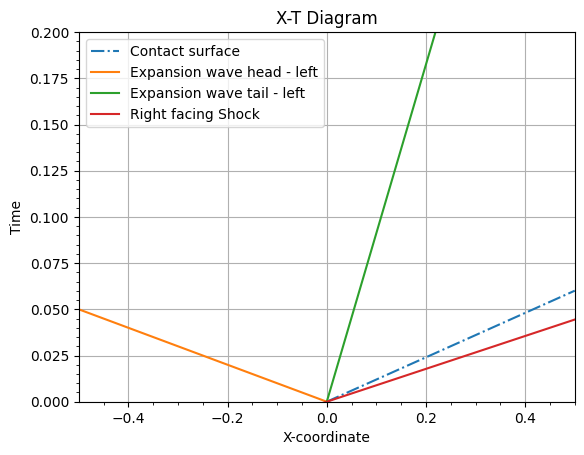

In [4]:

# Problem 1 ---------------------------------------------------------------------
primitive_left = [8.0, 0.0, 480]  # density, velocity, pressure
primitive_right = [1.0, 0.0, 1.0]
gamma_gas = [5/3, 5/3]  # gamma_left, gamma_right
gas_constant = [287, 287]  # gas_constant_left, gas_constant_right

x_initial = 0.0
time_initial = 0.0
time_location = 0.04

'''
# Problem 2 ---------------------------------------------------------------------
primitive_left = [1.0, -2.0, 0.4]  # density, velocity, pressure
primitive_right = [1.0, 2.0, 0.4]
gamma_gas = [1.4, 1.4]  # gamma_left, gamma_right
gas_constant = [287, 287]  # gas_constant_left, gas_constant_right

x_initial = 0.0
time_initial = 0.0
time_location = 0.15
'''
'''
# Problem 3 ---------------------------------------------------------------------
primitive_left = [1.0, -19.59745, 1000]  # density, velocity, pressure
primitive_right = [1.0, -19.59745, 0.01]
gamma_gas = [1.4, 1.4]  # gamma_left, gamma_right
gas_constant = [287, 287]  # gas_constant_left, gas_constant_right

x_initial = 0.3
time_initial = 0.0
time_location = 0.012
'''
x_range = [-0.5,0.5]

x_value, density, velocity, pressure = riemann_solver(primitive_left, primitive_right, gamma_gas, gas_constant, \
                                                     x_initial, x_range, time_initial, time_location)

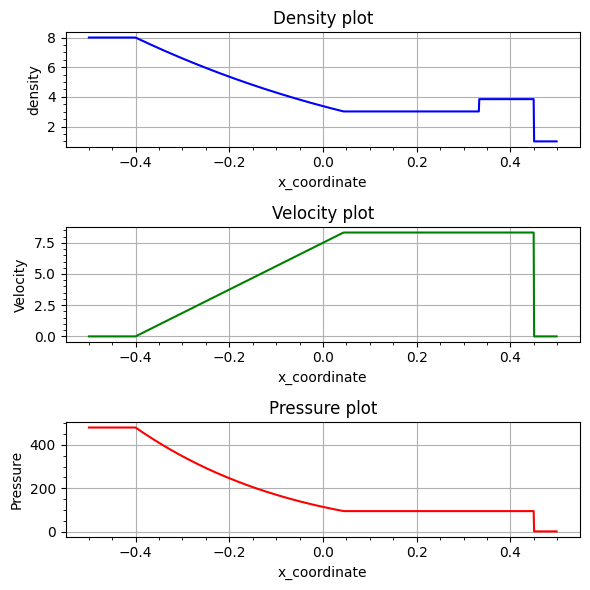

In [5]:
# Create a figure and three subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 6))

# Plot the first set of data in the first subplot
axs[0].plot(x_value, density, color='blue')
axs[0].set_xlabel('x_coordinate')
axs[0].set_ylabel('density')
axs[0].set_title('Density plot')
axs[0].grid(True)  # Enable major grid
axs[0].minorticks_on()  # Enable minor ticks


# Plot the second set of data in the second subplot
axs[1].plot(x_value, velocity, label = 'velocity', color='green')
axs[1].set_xlabel('x_coordinate')
axs[1].set_ylabel('Velocity')
axs[1].set_title('Velocity plot')
axs[1].grid(True)  # Enable major grid
axs[1].minorticks_on()  # Enable minor ticks

# Plot the third set of data in the third subplot
axs[2].plot(x_value, pressure, label = 'pressure', color='red')
axs[2].set_xlabel('x_coordinate')
axs[2].set_ylabel('Pressure')
axs[2].set_title('Pressure plot')
axs[2].grid(True)  # Enable major grid
axs[2].minorticks_on()  # Enable minor ticks

# Adjust layout to prevent subplot overlap
plt.tight_layout()

# Saving the figur`e
#plt.savefig('Problem_1_variable plots.png', dpi=300)

# Show the plot
plt.show()

In [6]:
##**********Writing data into txt file*******************##---------------------------
# Combine the data into tuples
combined_data = zip(x_value, density, velocity, pressure)

# Specifing the output file path
output_file_path = 'RSProblem1.txt'

# Opeing the file in write mode and write the data
with open(output_file_path, 'w') as file:
    # Write header
    file.write("\t  x            rho\t          V\t          P\n")

    # Writing data in scientific notation with 4 decimal points
    for data_point in combined_data:
        formatted_data = '\t'.join(["{:.4e}".format(value) for value in data_point])
        file.write(formatted_data + '\n')

print(f"Data has been written to {output_file_path}")

Data has been written to RSProblem1.txt
